http://www.pnas.org/content/93/19/10078.long

## Packages and formating

Import packages

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import rc

commands and definitions for nice latex rendering

In [4]:
#for latex-rendering. (I guess with a lot of redundancy.. but it works!)
rc('text', usetex=True) #
plt.rcParams['text.usetex'] = True #this line turns "ticks" on axis into latex  (i think is it the same function as the line above. not sure. )
plt.rcParams['text.latex.unicode'] = True 
#for the size of the exported figures
plt.rcParams['figure.figsize'] = (24, 18)
rc('text.latex', preamble=r'\usepackage{cmbright}')#this line turns text in legends for instance into latex


def round_to_n(x, n):
    " Round x to n significant figures "
    return round(x, -int(math.floor(np.sign(x) * math.log10(abs(x)))) + n)

def str_fmt(x, n=2):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"${} \, 10^{{ {} }}$".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)
    
def str_fmt_round_numb(x, n=1):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        power = int(np.log10(round_to_n(x, 0)))-1
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)

def str_fmt_name_fig(x, n=2):
    " Format x into nice text - rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"{}*10({})".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"{}*10^({ })".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"{}*10^({ })".format(f_SF, power)
    else:
        return r"{}$".format(x)
    


## Endode equations of the model and a set of default parameters

Choose values for parameters

In [5]:
scale = 1

tmax = 30        #solve the system of ODEs from t=0 to tmax (about 30 min for the cell to divide)
tmaxLONG = 1000  #what would be the steady state? (look at longer times)
 


WTV = 0.0023*scale  #not used in the code - small to have a small input in the cascade, cf Ferrell.. *)
rasgapV = .0002*scale # not used 

k11V = 1 #(* randomly chosen *)
k12V = 1

d11V = 1 #(* randomly chosen *)
d12V = 1 #(* randomly chosen *)
a11V = 10000/scale #(* randomly chosen *)
a12V = 10000/scale #(* randomly chosen *)
nn = 10

mostotV = .003*scale
mektotV = 1.2*scale #(*1.2*)
mekpasetotV = .0003*scale
mapktotV = 1.2*scale
mapkpasetotV = .12*scale
e2totV = 0.0003*scale


a1V = 1000/scale
a2V = 1000/scale
a3V = 1000/scale #(* for crossing 10 *)
a4V = 1000/scale #(* for crossing 500 *)
a5V = 1000/scale
a6V = 1000/scale
a7V = 1000/scale
a8V = 1000/scale
a9V = 1000/scale
a10V = 1000/scale


d1V = 150 #(* for crossing 15 *)
d2V = 150
d3V = 150
d4V = 150
d5V = 150
d6V = 150
d7V = 150
d8V = 150
d9V = 150
d10V = 150


k1V = 150
k2V = 150
k3V = 150
k4V = 150
k5V = 150
k6V = 150
k7V = 150
k8V = 150
k9V = 150
k10V = 150

rasgtp_inputV=1*scale

Encode equations of the model

In [6]:
var_names = 'mos', 'mose1', 'mosstar', 'mosstare2', 'mek', 'mekmosstar', 'mekstar', 'mekstarmekpase', 'mekstarmosstar', \
    'mekstarstar', 'mekstarstarmekpase', 'mapk', 'mapkmekstarstar', 'mapkstar', \
    'mapkstarmekstarstar', 'mapkstarstar', 'mapkstarmapkpase', \
    'mapkstarstarmapkpase'
    
params_names = 'mostot', 'e2tot', 'mektot', 'mekpasetot', 'mapktot', 'mapkpasetot', \
    'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', \
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', \
    'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10','WT', 'rasgdp', 'WE1', 'WsE2','rasgtp_input'

def equationsmodel(var, t, params):
    
    mos, mose1, mosstar, mosstare2, mek, mekmosstar, mekstar, mekstarmekpase, mekstarmosstar,\
    mekstarstar,mekstarstarmekpase, mapk, mapkmekstarstar, mapkstar, \
    mapkstarmekstarstar, mapkstarstar, mapkstarmapkpase, \
    mapkstarstarmapkpase = var
    
    mostot, e2tot, mektot, mekpasetot, mapktot, mapkpasetot, \
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, \
    d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, \
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, WT, rasgdp, WE1, WsE2, rasgtp_input = params
    
    dmos = -a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*(rasgtp_input - mose1) + d1*mose1 +\
    k2*mosstare2
    
    dmose1 = a1*(mostot - mosstar - mose1 - mosstare2 - mekmosstar - \
    mekstarmosstar)*(rasgtp_input - mose1) -(d1+k1)*mose1
    
    dmosstar = -a2*mosstar*(e2tot - mosstare2) + d2*mosstare2 + k1*mose1 + \
    (k3 + d3)*mekmosstar -  a3*mosstar*(mektot - mekstar - mekstarstar - \
    mekstarmekpase - mekstarstarmekpase - mekmosstar - mekstarmosstar - \
    mapkmekstarstar - mapkstarmekstarstar) + (k5 + d5)* mekstarmosstar - \
    a5*mekstar*mosstar
      
    dmosstare2 = a2*mosstar*(e2tot - mosstare2) - (d2 + k2)*mosstare2
    
    dmek = -a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar + d3*mekmosstar + k4*mekstarmekpase
     
    dmekmosstar = a3*(mektot - mekstar - mekstarstar - mekstarmekpase - \
    mekstarstarmekpase - mekmosstar - mekstarmosstar - mapkmekstarstar - \
    mapkstarmekstarstar)*mosstar - (d3 + k3)*mekmosstar
    
    dmekstar = -a4*mekstar*(mekpasetot - mekstarmekpase - mekstarstarmekpase)\
    + d4*mekstarmekpase + k3*mekmosstar + k6*mekstarstarmekpase + \
    d5*mekstarmosstar - a5*mekstar*mosstar
    
    dmekstarmekpase = a4*mekstar*(mekpasetot - mekstarmekpase - \
    mekstarstarmekpase)-(d4 + k4)*mekstarmekpase 

    dmekstarmosstar = a5*mekstar*mosstar - (d5 + k5)*mekstarmosstar
    
    dmekstarstar = k5*mekstarmosstar - a6*mekstarstar*(mekpasetot - 
    mekstarmekpase - mekstarstarmekpase) + d6*mekstarstarmekpase - \
    a7*mekstarstar*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar) + \
    (d7 + k7)*mapkmekstarstar + (d9 + k9)*mapkstarmekstarstar - \
    a9*mapkstar*mekstarstar
    
    dmekstarstarmekpase = a6*mekstarstar*(mekpasetot - mekstarmekpase \
    - mekstarstarmekpase) - (d6 + k6)*mekstarstarmekpase
    
    dmapk = -a7*(mapktot - mapkstar - mapkstarstar - mapkstarmapkpase - \
    mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar \
    + d7*mapkmekstarstar + k8*mapkstarmapkpase
    
    dmapkmekstarstar = a7*(mapktot - mapkstar - mapkstarstar \
    - mapkstarmapkpase - mapkstarstarmapkpase - mapkmekstarstar - mapkstarmekstarstar)*mekstarstar - (d7 + k7)*mapkmekstarstar
    
    dmapkstar = k7*mapkmekstarstar - a8*mapkstar*(mapkpasetot - \
    mapkstarmapkpase - mapkstarstarmapkpase) + d8*mapkstarmapkpase - \
    a9*mapkstar*mekstarstar + d9*mapkstarmekstarstar + k10*mapkstarstarmapkpase
    
    dmapkstarmekstarstar =a9*mapkstar*mekstarstar - (d9 + k9)*mapkstarmekstarstar
    
    dmapkstarstar = -a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) + d10*mapkstarstarmapkpase + k9*mapkstarmekstarstar 
    
    dmapkstarmapkpase = a8*mapkstar*(mapkpasetot - mapkstarmapkpase - 
    mapkstarstarmapkpase) - (d8 + k8)*mapkstarmapkpase
    
    dmapkstarstarmapkpase = a10*mapkstarstar*(mapkpasetot - mapkstarmapkpase - \
    mapkstarstarmapkpase) - (d10 + k10)*mapkstarstarmapkpase
     
    return [dmos, dmose1,dmosstar,dmosstare2,dmek,dmekmosstar,dmekstar, \
    dmekstarmekpase, dmekstarmosstar, dmekstarstar, dmekstarstarmekpase, \
    dmapk, dmapkmekstarstar, dmapkstar, dmapkstarmekstarstar, dmapkstarstar, \
    dmapkstarmapkpase, dmapkstarstarmapkpase]


In [7]:
param_v  = [mostotV, e2totV, mektotV, mekpasetotV, mapktotV, mapkpasetotV, \
    a1V, a2V, a3V, a4V, a5V, a6V, a7V, a8V, a9V, a10V, \
    d1V, d2V, d3V, d4V, d5V, d6V, d7V, d8V, d9V, d10V, \
    k1V, k2V, k3V, k4V, k5V, k6V, k7V, k8V, k9V, k10V,WTV,e2totV,0,0,rasgtp_inputV]

In [9]:
for kk in range(len(params_names)):
    print(params_names[kk],param_v[kk] )
    

mostot 0.003
e2tot 0.0003
mektot 1.2
mekpasetot 0.0003
mapktot 1.2
mapkpasetot 0.12
a1 1000.0
a2 1000.0
a3 1000.0
a4 1000.0
a5 1000.0
a6 1000.0
a7 1000.0
a8 1000.0
a9 1000.0
a10 1000.0
d1 150
d2 150
d3 150
d4 150
d5 150
d6 150
d7 150
d8 150
d9 150
d10 150
k1 150
k2 150
k3 150
k4 150
k5 150
k6 150
k7 150
k8 150
k9 150
k10 150
WT 0.0023
rasgdp 0.0003
WE1 0
WsE2 0
rasgtp_input 1


In [8]:
###################################
# INITIAL CONDTIONS
###################################

initialcond = np.zeros(len(var_names))
initialcond[0] = param_v[0]
initialcond[4] = param_v[2]
initialcond[11] = param_v[4]
###################################
# time array & array to store the output for various input levels of sos
###################################

tStop = tmax
tInc = 0.01
t = np.arange(0., tStop, tInc)

print("The initial conditions are {}(0) = {}, {}(0) = {} and {}(0) = {}".format(var_names[0],params_names[0], \
                                                                 var_names[4],params_names[2], \
                                                                 var_names[11],params_names[4]))
len(initialcond)



The initial conditions are mos(0) = mostot, mek(0) = mektot and mapk(0) = mapktot


18

## Loop over input, solve equations, and store value reached by the output 

We have a system with one input (the concentration of rasdtp which is not directly a parameter of our model, it is computed from the value of rasgdp...). We take $maxn$ different input values and plot only 5 solutions. 

In [13]:
maxn = 100
inputlist=np.logspace(-10, 1, num=maxn)*scale
maxplots=5;
selectedinput=range(1,maxn,divmod(maxn,maxplots)[0])#we plot only n=maxplots plots 
storeoutput=[]
print(params_names[4],param_v[4])

mapktot 1.2


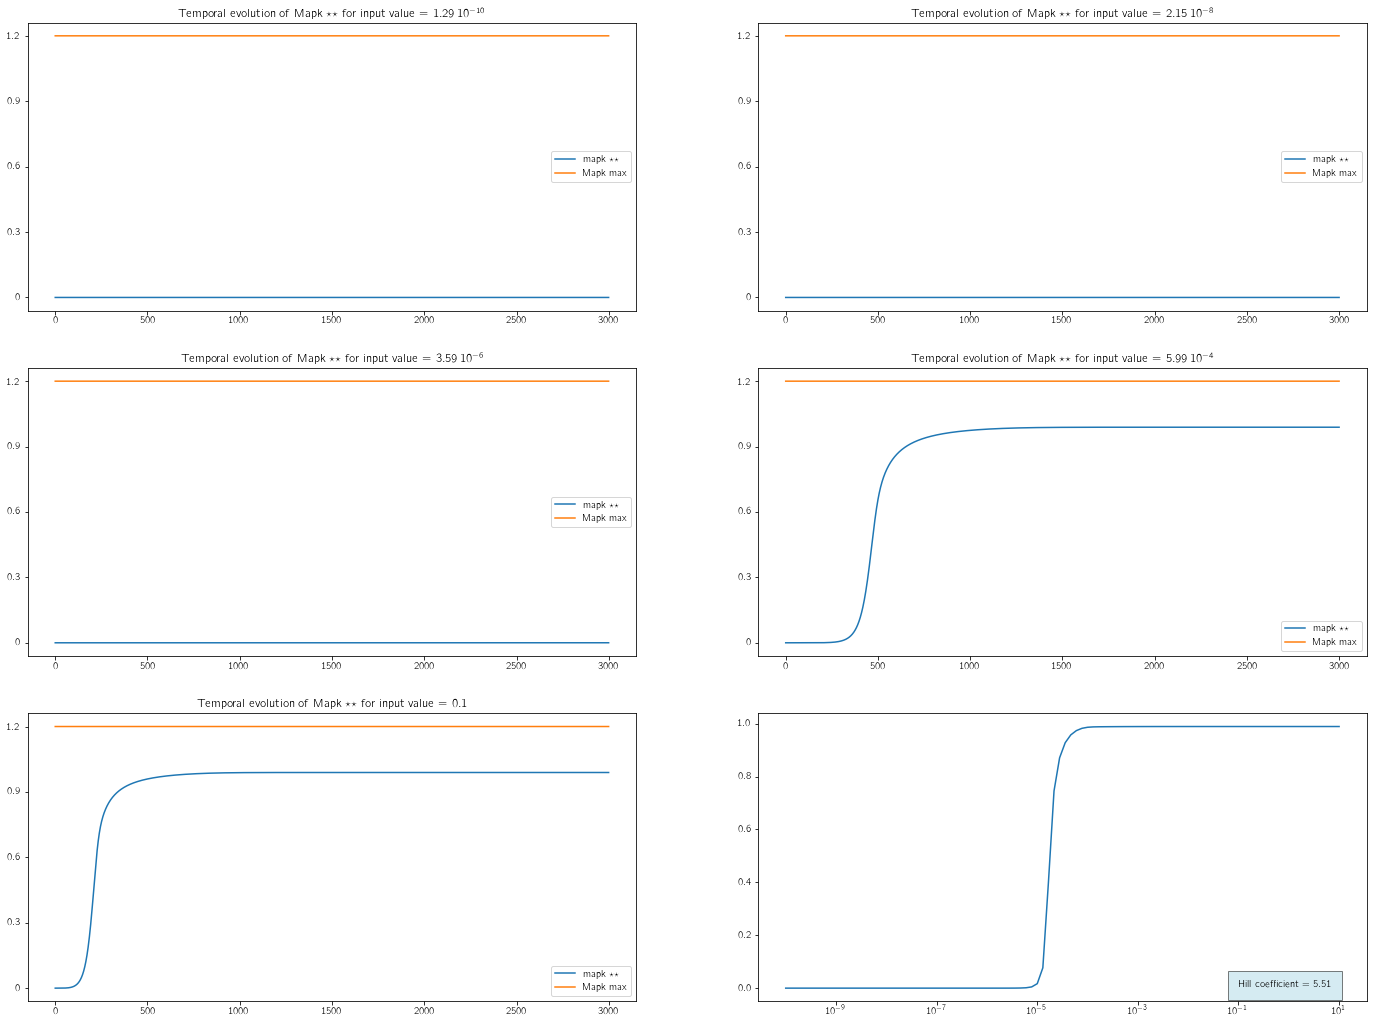

In [96]:
#to number plots    np.arange(1,math.floor(len(range(0,maxn,divmod(maxn,10)[0])))+1)

fig=plt.figure()
plotnumber=0
output=np.zeros(len(inputlist))

for kk in range(len(inputlist)):
    #value of input:
    param_v[40]=inputlist[kk]
    #actually solving the equations:
    psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
    output[kk]=psoln[len(t)-1,15]
    if kk in selectedinput:
        plotnumber=plotnumber+1
        plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber)
        plt.plot(psoln[:,15],label=r"$ \textnormal{mapk \star \star}$")
        #plot max value of mapk star star
        plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
        plt.legend()
        plt.title(r'Temporal evolution of Mapk $\star \star$ for input value = {}'.format(str_fmt(param_v[40],n=2)))
        plt.yticks([0, param_v[4]/4, param_v[4]/2, 3*param_v[4]/4, param_v[4]],
        ['$0$', r'{}'.format(str_fmt(param_v[4]/4)), r'{}'.format(str_fmt(param_v[4]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[4]/4,2))), r'{}'.format(str_fmt(param_v[4]))])

        
hillc=hillcoef(inputlist,output,equationsmodel,initialcond, t,param_v,index_param_input=40,index_output=15,numberpoints=100)
ax=plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber+1)
ax.set_xscale('log')
ax.plot(inputlist,output)
plt.text(0.1,0,r'Hill coefficient = {}'.format(round_to_n(hillc,2)), style='italic',bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
#plt.text(0,3*max(output)/4, r'Hill coefficient = {}'.format(round_to_n(hillc,2)), style='italic',bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})

plt.show()




In [79]:
def hillcoef(input,output,equationsmodel,initialcond, t,param_v,index_param_input=40,index_output=15,numberpoints=100):
    "This function compute the Hill coefficient for a given a rough input/output set of points" 
    "It needs the ODEs that give the output given the input, the initial cnoditon, a time vector to solve ODEs"
    "The parameters involved in the ODEs and the index of the parameter that correspond to changing the input"
    "numberpoints: specify how many points we add localy to find the inputs giving .1 and .9 of the maxoutput"
    maxoutput=max(output)
    #
    approxloc09=np.abs(output-.9*maxoutput).argmin()#position in the array of approximate location
    input09=np.linspace(input[approxloc09-2],input[approxloc09+2],numberpoints)#generate more output points near that approximate location 
    output09=[-1]#initiate the local output array
    #
    #
    for i in range(0,len(input09)):
        param_v[index_param_input]=input09[i]
        psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
        outputtostore=psoln[len(t)-1,index_output]
        output09=np.append(output09,[outputtostore])
    # 
    output09=output09[1:]
    inversef=interp1d(output09,input09)
    loc09=inversef(.9*maxoutput)
    #
    #
    approxloc01=np.abs(output-.1*maxoutput).argmin()#position in the array of approximate location
    input01=np.linspace(input[approxloc01-2],input[approxloc01+2],numberpoints)#generate more output points near that approximate location 
    output01=[-1]
    #
    #
    for i in range(0,len(input01)):
        param_v[index_param_input]=input01[i]
        psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
        outputtostore=psoln[len(t)-1,index_output]
        output01=np.append(output01,[outputtostore])
    # 
    output01=output01[1:]
    inversef=interp1d(output01,input01)
    loc01=inversef(.1*maxoutput)
    #
    return math.log(81)/math.log(loc09/loc01)
    


In [76]:
hillcoef(inputlist,output,equationsmodel,initialcond, t,param_v)

5.509472818861475